# importing acl-anthology bib file & creating csv

In [72]:
import requests
import gzip
import shutil
import os
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/nell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [77]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [643]:
import pandas as pd
import sre_yield

# define keywords & words to exclude

# 'asymmetry', 
# , 'personal attribute', 'protected attribute', 'protected categor', 'social group signals', 'stereotype'
df = pd.DataFrame()

keywords = ['bias', 'fairness', 'protected category', 'stereotype', 'social group signal']

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            temp_row = {}

            # select only select papers from 2016 on
            if 'year' in paper.keys() and int(paper['year']) >= 2016:

                for cat in paper.keys():
                    temp_row[cat] = paper[cat]

                df = pd.concat([df, pd.DataFrame([temp_row])], ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [644]:
print(len(df))

1061


In [561]:
# uncomment if csv is already in directory (and save time parsing the bib file)
import pandas as pd
df = pd.read_csv('bias_paper_reduced.csv')
print(len(df))

494


In [406]:
df.head()

,abstract,pages,doi,url,publisher,address,year,month,booktitle,author,title,ENTRYTYPE,ID,volume,journal,number,language,isbn
0,Machine-learned models for author profiling in social media often rely on data acquired via self...,315--323,10.18653/v1/2022.wassa-1.35,https://aclanthology.org/2022.wassa-1.35,Association for Computational Linguistics,"Dublin, Ireland",2022,May,"Proceedings of the 12th Workshop on Computational Approaches to Subjectivity, Sentiment {\&} Soc...","Kreuter, Anne and\nSassenberg, Kai and\nKlinger, Roman",Items from Psychometric Tests as Training Data for Personality Profiling Models of {T}witter Users,inproceedings,kreuter-etal-2022-items,NaN,NaN,NaN,NaN,NaN
1,"Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all...",73--91,10.1162/tacl_a_00448,https://aclanthology.org/2022.tacl-1.5,MIT Press,"Cambridge, MA",2022,NaN,NaN,"Clark, Jonathan H. and\nGarrette, Dan and\nTurc, Iulia and\nWieting, John",Canine: Pre-training an Efficient Tokenization-Free Encoder for Language Representation,article,clark-etal-2022-canine,10,Transactions of the Association for Computational Linguistics,NaN,NaN,NaN
2,Majority voting and averaging are common approaches used to resolve annotator disagreements and ...,92--110,10.1162/tacl_a_00449,https://aclanthology.org/2022.tacl-1.6,MIT Press,"Cambridge, MA",2022,NaN,NaN,"Davani, Aida Mostafazadeh and\nD{\'\i}az, Mark and\nPrabhakaran, Vinodkumar",Dealing with Disagreements: Looking Beyond the Majority Vote in Subjective Annotations,article,davani-etal-2022-dealing,10,Transactions of the Association for Computational Linguistics,NaN,NaN,NaN
3,Pretrained contextualized language models such as BERT and T5 have established a new state-of-th...,224--239,10.1162/tacl_a_00457,https://aclanthology.org/2022.tacl-1.13,MIT Press,"Cambridge, MA",2022,NaN,NaN,"MacAvaney, Sean and\nFeldman, Sergey and\nGoharian, Nazli and\nDowney, Doug and\nCohan, Arman",{ABNIRML}: Analyzing the Behavior of Neural {IR} Models,article,macavaney-etal-2022-abnirml,10,Transactions of the Association for Computational Linguistics,NaN,NaN,NaN
4,Incorporating stronger syntactic biases into neural language models (LMs) is a long-standing goa...,1--10,10.18653/v1/2022.spnlp-1.1,https://aclanthology.org/2022.spnlp-1.1,Association for Computational Linguistics,"Dublin, Ireland",2022,May,Proceedings of the Sixth Workshop on Structured Prediction for NLP,"Kando, Shunsuke and\nNoji, Hiroshi and\nMiyao, Yusuke",Multilingual Syntax-aware Language Modeling through Dependency Tree Conversion,inproceedings,kando-etal-2022-multilingual,NaN,NaN,NaN,NaN,NaN


# tf-idf & clustering

In [407]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [645]:
import re
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")  
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(w) for w in tokens if not lemmatizer.lemmatize(w.lower()) in stopwords_list]
        text = " ".join(tokens)
    
    text = text.lower().strip()
    
    return text

In [646]:
# create cleaned column
df['cleaned_w_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True)) \
                + df['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df['cleaned_wo_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [648]:
excludes = ['algorithmic bias', 'inductive bias', 'media bias', 'model bias', 'modelling bias', 
            'common sense bias', 'hyperpartisan news', 'hypothesis bias', 'position bias', 'statistical bias', 
            'system bias', 'learned bias', ' les ', ' des ', ' en ']
df = df[~df['cleaned_w_title'].str.contains('|'.join(excludes))]

In [649]:
print(len(df))

894


In [650]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned_w_title'])
Y = vectorizer.fit_transform(df['cleaned_wo_title'])

In [651]:
print(f'entries: {len(df.index)}')

entries: 894


In [652]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# elbow-test

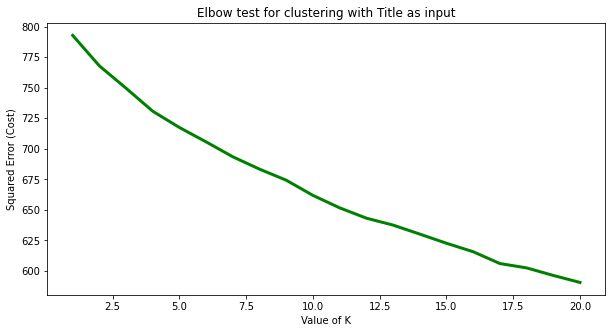

In [337]:
import matplotlib.pyplot as plt

def elbow_test(data, max_k=16, max_iter=500):
    # perform elbow test
    cost =[]
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, max_iter=max_iter)
        kmeans.fit(data)

        # calculates squared error
        # for the clustered points
        cost.append(kmeans.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, max_k), cost, color ='g', linewidth ='3')
    plt.title("Elbow test for clustering with Title as input")
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot

elbow_test(X, max_k=21)

# PCA & KMeans

In [656]:
def make_pca_vecs(data, n_clusters=5):
# vary here the number of clusters
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(data)
    clusters = kmeans.labels_
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(data.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return clusters, clusters, x0, x1

In [657]:
# assign clusters and pca vectors to our dataframe 
clusters_df, df['cluster'], df['x0'], df['x1'] = make_pca_vecs(X, n_clusters=3)

In [658]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [659]:
def get_top_keywords(this_df, data, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(df, X, clusters_df, 10)



Cluster 1
machine,research,embeddings,often,sentence,prediction,distribution,metric,label,translation

Cluster 2
corpus,generation,state,human,problem,quality,biased,address,network,embeddings

Cluster 3
representation,technique,network,address,generation,quality,social,biased,classification,detection


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [660]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               3: "cluster 04", 
               4: "cluster 05", 
               5: "cluster 06", 
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

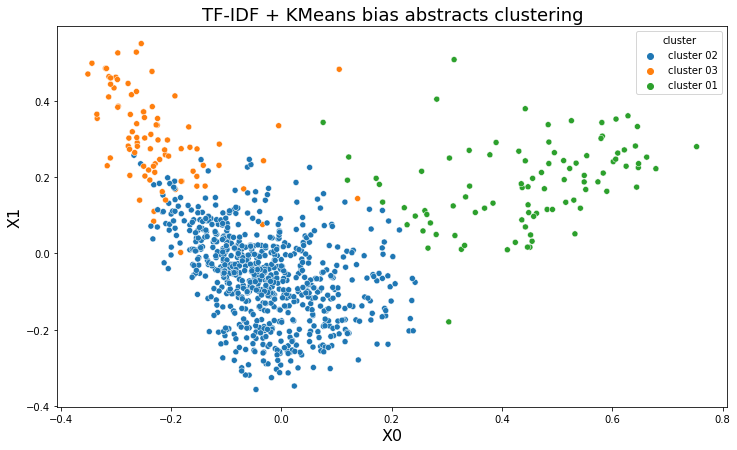

In [661]:
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

def make_kmeans_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='cluster')
    plt.show()
    
make_kmeans_plot(df)

# stats & plots

## ngram analysis

In [699]:
from nltk.util import ngrams
from collections import Counter

def count_ngrams(this_df, num, keyword_list, pos):
    
    all_ngrams = []
    bias_ngrams = []
    
    for idx, row in this_df.iterrows():
        tokens = nltk.word_tokenize(row['cleaned_w_title'])
        ngrams = set(nltk.ngrams(tokens, num))
        all_ngrams += ngrams
        
    frequence = Counter(all_ngrams)

    for entry, value in frequence.most_common():
        if entry[pos] in keyword_list:
            bias_ngrams.append((entry, value))
    
    if bias_ngrams:
        return bias_ngrams
    return frequence.most_common()


print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df, 2, [''], 0)[:30])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, [''], 0)[:40])
print()
print('POSITION 0')
print('BIGRAMS')
print(count_ngrams(df, 2, ['bias', 'biases'], 0)[:20])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bias', 'biases'], 0)[:40])
print('BIGRAMS')
print()
print('POSITION 1')
print(count_ngrams(df, 2, ['bias', 'biases'], 1)[:20])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bias', 'biases'], 1)[:40])
print()
print('POSITION 2')
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bias', 'biases'], 2)[:40])

MOST COMMON
BIGRAMS
[(('natural', 'language'), 157), (('state', 'art'), 149), (('language', 'model'), 114), (('gender', 'bias'), 107), (('e', 'g'), 105), (('language', 'processing'), 86), (('machine', 'translation'), 82), (('training', 'data'), 77), (('word', 'embeddings'), 75), (('pre', 'trained'), 68), (('model', 'trained'), 57), (('experimental', 'result'), 56), (('neural', 'network'), 53), (('result', 'show'), 53), (('machine', 'learning'), 53), (('real', 'world'), 53), (('paper', 'propose'), 51), (('exposure', 'bias'), 48), (('large', 'scale'), 47), (('propose', 'novel'), 47), (('fine', 'tuning'), 46), (('question', 'answering'), 45), (('et', 'al'), 44), (('neural', 'machine'), 44), (('social', 'medium'), 42), (('language', 'models'), 38), (('social', 'bias'), 38), (('paper', 'present'), 37), (('widely', 'used'), 37), (('proposed', 'method'), 36)]

TRIGRAMS
[(('natural', 'language', 'processing'), 83), (('neural', 'machine', 'translation'), 43), (('pre', 'trained', 'language'), 27

## type of bias plot

In [663]:
# hand crafted bias list (feel free to change)
bias_list = ['age', 'diachronic', 'entity', 'ethnic', 'exposure', 'gender', 
             'race', 'religion', 'social', 'societal']

# ONE HOT ENCODING
def one_hot(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df[i] = this_df['cleaned_w_title'].str.split().apply(lambda x: i in x)
        
def add_not_spec_col(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df.loc[(this_df[i] == True), 'not_specified'] = False
        
    this_df.loc[(this_df['not_specified'].isnull()), 'not_specified'] = True
        
one_hot(df)
add_not_spec_col(df)

In [664]:
def count_biases(this_df, bias_list=bias_list):
    counts = []
    for i in bias_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['not_specified'].value_counts())
    
    return counts

age               5
diachronic        1
entity            3
ethnic            5
exposure          0
gender           46
race             10
religion          3
societal          3
not_specified    55
Name: True, dtype: int64


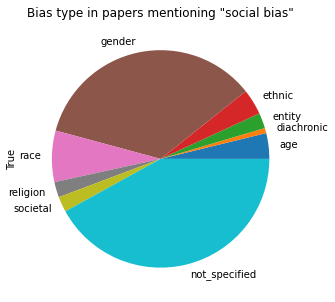

In [665]:
def count_social_biases(this_df, bias_list=bias_list):
    counts = []
    temp_df = pd.DataFrame()
    for i in bias_list:
        if i == 'social':
            continue
        temp_df[i] = pd.crosstab(this_df[i],this_df['social']).loc[True]
        
    temp_df['not_specified'] = this_df['social'].value_counts() - temp_df.sum(axis=True)
                
    temp_df.loc[True].plot.pie(figsize=(5, 5));
    plt.title('Bias type in papers mentioning "social bias"')
        
    return temp_df.loc[True]

print(count_social_biases(df, bias_list=bias_list))

               False  True
age              875    19
diachronic       887     7
entity           824    70
ethnic           885     9
exposure         846    48
gender           710   184
race             861    33
religion         885     9
social           763   131
societal         871    23
not_specified    391   503


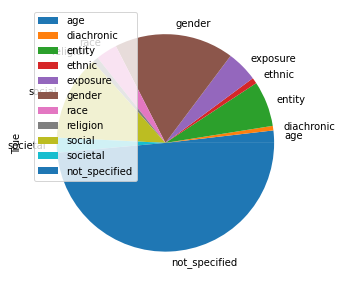

In [701]:
def plot_counts(this_df):
    df_counts = pd.concat(count_biases(this_df), axis=1).transpose()
    print(df_counts)
    df_counts.plot.pie(y=True, figsize=(5, 5));
    
plot_counts(df)

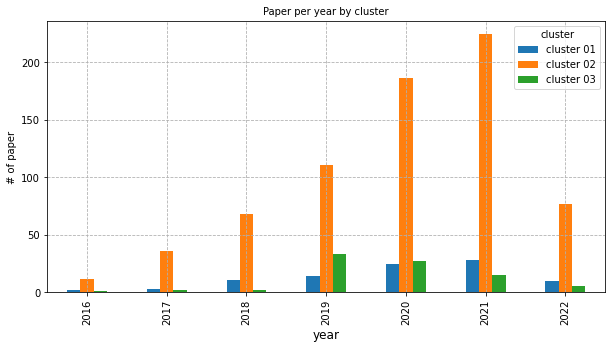

In [667]:
# year per cluster
def year_per_clust_plot(this_df):
    pd.crosstab(this_df['year'],this_df['cluster']).plot.bar();
    plt.title('Paper per year by cluster', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_clust_plot(df)

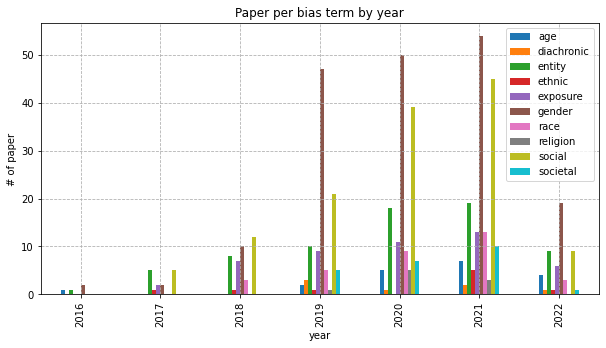

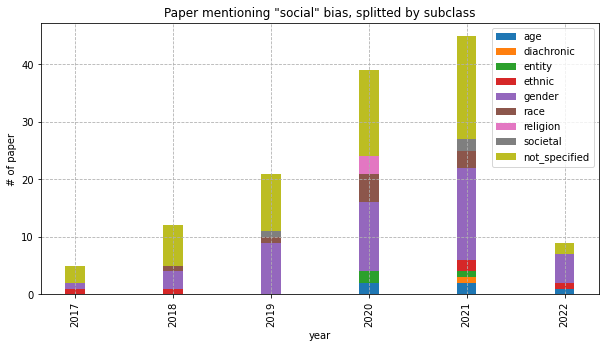

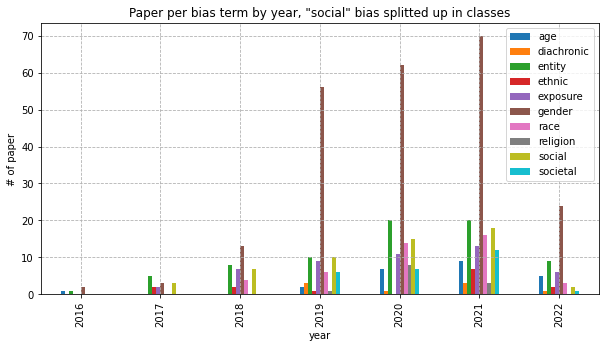

In [697]:
# bias per year
def bias_per_year_plot(this_df, bias_list=bias_list):
    
    temp_df = pd.DataFrame()
    social_df = pd.DataFrame()
    this_social_df = this_df.loc[this_df['social'] == True]
    
    for i in bias_list:
        
        temp_df[i] = pd.crosstab(this_df[i],this_df['year']).loc[True]
        
        if i == 'social':
            continue
        
        if this_social_df[i].any():
            social_df[i] = pd.crosstab(this_social_df[i],this_social_df['year']).loc[True]    
    
    social_df['not_specified'] = temp_df['social'] - social_df.sum(axis=1)
    social_df['not_specified'] = social_df['not_specified'].astype('Int64')
    social_df = social_df.fillna(0)
        
    #temp_df['not_specified'] = pd.crosstab(this_df['not_specified'],this_df['year']).loc[True]
    #temp_df['not_specified'] = temp_df['not_specified'].astype('Int64')
    
    social_splitted_df = temp_df.copy()
    social_splitted_df = social_splitted_df.add(social_df, fill_value=0)
    social_splitted_df['social'] = social_df['not_specified']
    social_splitted_df = social_splitted_df.drop('not_specified',axis=1)
    
    temp_df.plot(kind='bar', stacked=False);
    plt.title('Paper per bias term by year')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
    social_df.plot(kind='bar', stacked=True, width=0.2);
    plt.title('Paper mentioning "social" bias, splitted by subclass')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
    social_splitted_df.plot(kind='bar', stacked=False);
    plt.title('Paper per bias term by year, "social" bias splitted up in classes')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
bias_per_year_plot(df)

In [708]:
# N-GRAM analysis of not specified bias

print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 2, [''], 0)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 3, [''], 0)[:40])
print()
print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 2, ['bias', 'biases'], 1)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 3, ['bias', 'biases'], 0)[:40])
print()

MOST COMMON
BIGRAMS
[(('natural', 'language'), 96), (('state', 'art'), 94), (('language', 'model'), 63), (('e', 'g'), 50), (('language', 'processing'), 43), (('training', 'data'), 43), (('machine', 'translation'), 43), (('experimental', 'result'), 41), (('question', 'answering'), 39), (('neural', 'network'), 38), (('pre', 'trained'), 34), (('result', 'show'), 32), (('fine', 'tuning'), 29), (('real', 'world'), 28), (('model', 'trained'), 26), (('machine', 'learning'), 26), (('paper', 'present'), 26), (('large', 'scale'), 26), (('et', 'al'), 26), (('neural', 'machine'), 26), (('propose', 'novel'), 25), (('paper', 'propose'), 23), (('proposed', 'method'), 22), (('recent', 'work'), 22), (('language', 'models'), 20), (('text', 'classification'), 20), (('high', 'quality'), 20), (('biased', 'towards'), 19), (('trained', 'language'), 19), (('work', 'propose'), 19), (('data', 'collection'), 19), (('bias', 'model'), 18), (('model', 'performance'), 18), (('bias', 'towards'), 18), (('sentiment', '

In [709]:
# N-GRAM analysis of social bias

print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['social'] == True)], 2, [''], 0)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['social'] == True)], 3, [''], 0)[:40])
print()
print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['social'] == True)], 2, ['bias', 'biases'], 1)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['social'] == True)], 3, ['bias', 'biases'], 0)[:40])
print()

MOST COMMON
BIGRAMS
[(('social', 'medium'), 42), (('social', 'bias'), 38), (('word', 'embeddings'), 23), (('natural', 'language'), 20), (('gender', 'bias'), 18), (('language', 'processing'), 17), (('e', 'g'), 16), (('language', 'model'), 16), (('training', 'data'), 15), (('state', 'art'), 13), (('hate', 'speech'), 12), (('social', 'science'), 12), (('model', 'trained'), 11), (('real', 'world'), 11), (('paper', 'propose'), 10), (('social', 'media'), 10), (('ha', 'shown'), 9), (('demographic', 'group'), 9), (('pre', 'trained'), 9), (('machine', 'learning'), 9), (('bias', 'present'), 8), (('case', 'study'), 8), (('bias', 'word'), 8), (('neural', 'model'), 8), (('word', 'embedding'), 8), (('work', 'ha'), 7), (('result', 'show'), 7), (('widely', 'used'), 7), (('speech', 'detection'), 7), (('nlp', 'system'), 7), (('nlp', 'task'), 7), (('e', 'nglish'), 6), (('research', 'ha'), 6), (('language', 'models'), 6), (('mitigate', 'bias'), 6), (('human', 'like'), 6), (('social', 'group'), 6), (('medi

In [44]:
# TODO 
# look at gender bias within social bias

## type of research plots

In [453]:
verb_list = {'analysis': ['analy', 'exploit', 'detect', 'investigat'], 
             'debiasing': ['mitigat', 'debias', 'reduc']} # list of verbs to get insights about the type of research


In [454]:
# ONE HOT ENCODING
def one_hot_verb(this_df, verb_list=verb_list):
    for key in verb_list.keys():
        for i in verb_list[key]:
            this_df[key] = this_df['cleaned_w_title'].str.contains(i)
            
        this_df.loc[(this_df[key] == True), 'no_verb'] = False   
    this_df.loc[(this_df['no_verb'].isnull()), 'no_verb'] = True

one_hot_verb(df)

[False    756
True     138
Name: analysis, dtype: int64, False    782
True     112
Name: debiasing, dtype: int64, debiasing
False    114
True      24
Name: True, dtype: int64, True     668
False    226
Name: no_verb, dtype: int64]


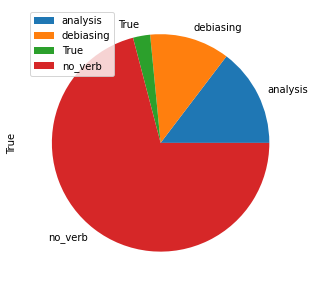

In [455]:
def plot_verb_count(this_df):
    counts = []
    for key in verb_list.keys():
        counts.append(this_df[key].value_counts())
    counts.append(pd.crosstab(this_df['analysis'],this_df['debiasing']).loc[True])
    counts.append(this_df['no_verb'].value_counts())
        
    print(counts)
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot.pie(y=True, figsize=(5, 5));
    
plot_verb_count(df)

## type of task plots

In [63]:
task_list = ['speech recognition', 'generation', 'translation', 'coreference resolution', 'role labeling',
             'pos-tagging', 'embedding', 'captioning', 'question answering', 'named entity recognition']


In [66]:
# ONE HOT ENCODING
def one_hot_task(this_df, task_list=task_list):
    for i in task_list:
        this_df[i] = this_df['cleaned_w_title'].str.contains(i)
            
        this_df.loc[(this_df[i] == True), 'no_task'] = False   
    this_df.loc[(this_df['no_task'].isnull()), 'no_task'] = True

one_hot_task(df)

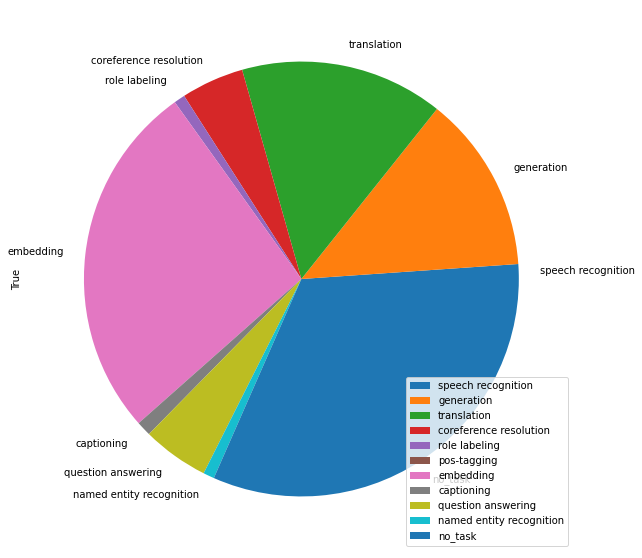

In [67]:
def plot_task_count(this_df):
    counts = []
    for i in task_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['no_task'].value_counts())
        
    #print(counts)
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot.pie(y=True, figsize=(10, 10));
    
plot_task_count(df)

## get citations

In [68]:
def get_first_author(this_df):
    this_df['author'] = this_df['author'].str.strip('{}')
    this_df['first_author'] = this_df['author'].str.split(pat=' and').str[0]
    this_df['first_author'] = this_df['first_author'].str.removesuffix(' ')
    this_df['first_author'] = this_df['first_author'].str.split(pat=', ').str[::-1]
    
get_first_author(df)

In [69]:
author_str = ' '.join(df['first_author'][0]).lower()

In [70]:
title_str = df['title'][0].lower()

In [71]:
# from https://github.com/ckreibich/scholar.py
%run scholar.py -c 1 --author f'{author_str}' --title f'{title_str}'

TypeError: slice indices must be integers or None or have an __index__ method

# Make and LDA

In [2]:
### LDA with inspiration from here: https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13#:~:text=Topic%20modelling%20in%20natural%20language%20processing%20is%20a%20technique%20which,important%20to%20categories%20the%20documents.
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(this_df, col, range_min=1, range_max=3, mindf=0.01, maxdf=0.5):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    vectorizer = CountVectorizer(ngram_range=(range_min, range_max), min_df=mindf, max_df=maxdf)
    Z = vectorizer.fit_transform(this_df[col])
    new_df = pd.DataFrame(Z.toarray(), columns = vectorizer.get_feature_names())
    
    return Z, new_df, vectorizer

Z_df, _, cv_df = get_bow(df, 'cleaned_w_title')


NameError: name 'df' is not defined

In [1]:
print(Z_df)

NameError: name 'Z_df' is not defined

In [28]:
# Use LDA to look for 6 topics
from sklearn.decomposition import LatentDirichletAllocation

def make_lda(this_df, Z, vectorizer, n_topics=6, n_words=10):
    model_lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    model_lda.fit(Z)

    feature_names = vectorizer.get_feature_names()

    topic_list = []
    for topic_idx, topic in enumerate(model_lda.components_):
        top_n = [feature_names[i]
                  for i in topic.argsort()
                   [-n_words:]][::-1]

        top_features = ' '.join(top_n)

        topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

        print(f"Topic {topic_idx}:\n{top_features}")
        print('\n')

    topic_result = model_lda.transform(Z)
    this_df['topic']  = topic_result.argmax(axis=1)
    
make_lda(df, Z_df, cv_df, n_topics=4)

Topic 0:
gender social models human analysis biases differences text demographic show


Topic 1:
gender gender bias word biases embeddings data models word embeddings translation nlp


Topic 2:
models model data training biases datasets performance show dataset learning


Topic 3:
news word biases embeddings different text media articles embedding model




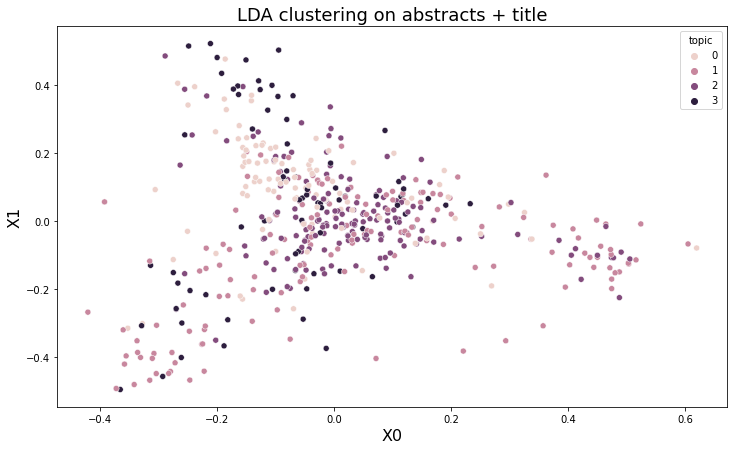

In [29]:
def make_lda_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("LDA clustering on abstracts + title", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='topic')
    plt.show()
    
make_lda_plot(df)

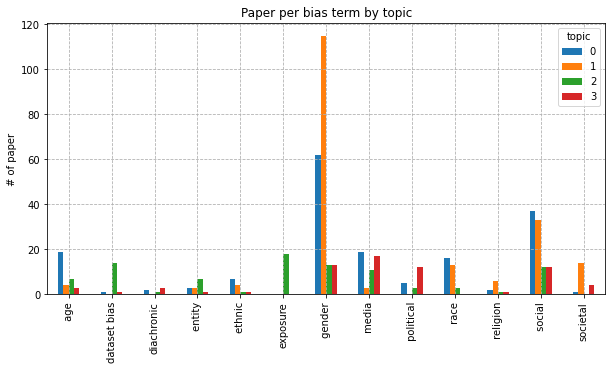

In [30]:
# topic per bias
def topic_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['topic']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by topic')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

topic_per_bias_plot(df)

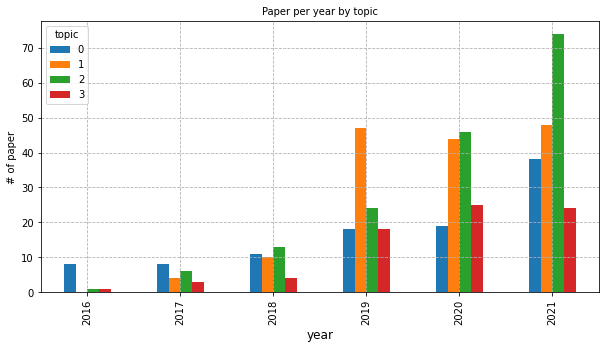

In [31]:
# year per topic
def year_per_topic_plot(this_df):
    pd.crosstab(this_df['year'],this_df['topic']).plot.bar();
    plt.title('Paper per year by topic', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_topic_plot(df)

In [32]:
# TODO
# how do cluster correspond to topic
df_ws = df[df['booktitle'].str.contains('Workshop', na=False)]
df_co = df[df['booktitle'].str.contains('Conference', na=False)]

def main(this_df, data, n_cluster=6, max_words=20, bias_list=bias_list, run_stats=True):
    # length of dataframe
    print(f'entries: {len(this_df.index)}')
    
    # create cluster & pca components & print keywords for cluster
    cluster, this_df['cluster'], this_df['x0'], this_df['x1'] = make_pca_vecs(data, n_cluster)
    get_top_keywords(this_df, data, cluster, max_words)
    this_df['cluster'] = this_df['cluster'].map(cluster_map)
    
    # create kmeans plot
    make_kmeans_plot(this_df)
    #elbow_test(data)
    
    # do one hot encoding & create stats plots
    if run_stats:
        one_hot(this_df)
        plot_counts(this_df)
        clust_per_bias_plot(this_df, bias_list)
        bias_per_year_plot(this_df, bias_list)
    
    year_per_clust_plot(this_df)
    
    # create lda vectorizer & perform LDA
    Z_df, _, cv_df = get_bow(this_df, 'cleaned_w_title')
    make_lda(this_df, Z_df, cv_df, n_topics=n_cluster)
    make_lda_plot(df)
    
    # stats of LDA
    if run_stats:
        topic_per_bias_plot(df)
        
    year_per_topic_plot(df)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# create vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)

In [ ]:
# ONLY LOOK AT WORKSHOP PAPERS
data1 = vectorizer.fit_transform(df_ws['cleaned_w_title'])
main(df_ws, data1, n_cluster=5)

In [ ]:
# ONLY LOOK AT CONFERENCE PAPERS
data2 = vectorizer.fit_transform(df_co['cleaned_w_title'])
main(df_co, data2, n_cluster=5)

In [ ]:
# ONLY LOOK AT PAPERS CONTAINING "SOCIAL"
df_social = df[df['abstract'].str.contains('social', na=False)]
data_social = vectorizer.fit_transform(df_social['cleaned_w_title'])
bias_list_social = [' age', ' race', ' gender', ' ethnic', ' religion']
main(df_social, data_social, n_cluster=5, bias_list=bias_list_social)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 3 CLUSTER
df_unspec = df[df['not_specified'] == True]
data_unspec = vectorizer.fit_transform(df_unspec['cleaned_w_title'])
main(df_unspec, data_unspec, n_cluster=3, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 2 CLUSTER
main(df_unspec, data_unspec, n_cluster=2, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 6 CLUSTER
main(df_unspec, data_unspec, n_cluster=6, run_stats = False)